In [1]:
import pandas as pd
import datetime
import tensorflow as tf
import keras
import seaborn
import numpy as np

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from matplotlib import pyplot



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-14 14:08:37.398151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


To do:
* Try K-fold per timeseries instead of timestep and shuffle
* Make overview of smape scores in validation
* Experiment with regularization
* Experiment  with different window size
* Smoothing

In [2]:
# Create fixed-window sequences for training and validation data
def create_sequences(X, window_size):
    seq_X = []
    seq_y = []
    for i in range(len(X) - window_size):
        seq_X.append(X[i:i+window_size])
        seq_y.append(X[i+window_size])
    return seq_X, seq_y

In [3]:
def reprocess(y, details):
    # print(details)
    mean = details[2][0]
    std = details[2][1]
    PF = details[2][2]
    PFtype = details[2][3]
    time = details[3]

    # print("mean:", mean, "std:", std, "PF", PF, "type", PFtype, "time", time)

    if(PFtype == 1):
        return ((y * std) + mean) * np.exp(PF[0] * time + PF[1])    
    # print("here")
    return (y * std + mean) * (PF[0] * np.square(time) + PF[1] * time + PF[2])


In [4]:
def preprocess(data):
    PFtype = -1
    PF1 = np.polyfit(np.linspace(0,len(data) - 1,num=len(data)), np.log(data), 1)
    PF2 = np.polyfit(np.linspace(0,len(data) - 1,num=len(data)),data, 2)
    error1 = data - (np.exp(PF1[0] * np.linspace(0, len(data) - 1, num=len(data)) + PF1[1]))
    error2 = data - (PF2[0] * np.square(np.linspace(0,len(data) - 1,num=len(data))) + PF2[1] * np.linspace(0, len(data) - 1, num=len(data)) + PF2[2])
    
    #Otto: dit is de keuze voro welke je preporcessed. je kan die plotjes un commenten om de fit te zien
    if(np.sum(np.square(error1)) < np.sum(np.square(error2))):
        PF = PF1
        preprocessed = data / (np.exp(PF[0] * np.linspace(0,len(data) - 1,num=len(data)) + PF[1]))
        PFtype = 1
    else:
        PF = PF2
        preprocessed = data / (PF2[0] * np.square(np.linspace(0,len(data) - 1,num=len(data))) + PF2[1] * np.linspace(0,len(data) - 1,num=len(data)) + PF2[2])
        PFtype = 2
    
    m = np.mean(preprocessed)
    s = np.std(preprocessed)
    preprocessed = (preprocessed - m)/s
    details = [m, s, PF, PFtype]
    
    return preprocessed, details

In [5]:
def preprocess2(data):

    PF = np.polyfit(np.linspace(0,len(data),num=len(data)), np.log(data), 1)

    preprocessed = data / (np.exp(PF[0] * np.linspace(0,len(data),num=len(data)) + PF[1]))
    m = np.mean(preprocessed)
    s = np.std(preprocessed)
    preprocessed = (preprocessed - m)/s

    details = [m, s, PF]

    return preprocessed, details

In [6]:
def smape_clean(y_true, y_pred):
    smape = 100 * np.mean(2*np.abs(y_pred - y_true) / (y_true + y_pred))
    return smape

In [7]:
def smape(model, validation):
    validation_x = []
    validation_y = []
    for val in validation:
        validation_x.append(val[0])
        validation_y.append(val[1])
    validation_x = np.array(validation_x)
    validation_y = np.array(validation_y)
    smape = 0
    prediction = model.predict(validation_x, verbose=0)
    # _, acc = model.evaluate(validation_x, validation_y, verbose = 0)

    # print("sse val is; ", np.sum(np.square(validation_y - prediction))/len(validation_y), "val is ", acc)
    for i in range(len(validation)):
        observation = validation[i]
        pred = prediction[i]
        #print(pred, observation[1], pred - observation[1])
        x_hat = reprocess(pred, observation)
        x = reprocess(observation[1], observation)
        #print(x_hat, x, x_hat - x)

        smape += 2*np.abs(x_hat-x)/(x+x_hat)

    smape /= len(validation)
    smape *=100

    return smape

In [8]:
def build_model(x_train, y_train, x_validation, y_validation, window_size, options): #x_validation, y_validation
    # Build the FFNN model
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(window_size, 1))) 
    model.add(keras.layers.Dense(options.layers[0], activation='sigmoid'))

    if len(options.layers) > 2:
        for i in range(1,len(options.layers)-1):
            model.add(keras.layers.Dense(options.layers[i], activation=options.activation))
                
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    #early stopping and saving the best model SOURCE: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50, min_delta=0.001)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    # fit model

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=options.batchSize, verbose = 0, callbacks=[es, mc], epochs= 1000) #fit the model with early stop

    ##this is the best model
    saved_model = load_model("best_model.h5")

    _, train_acc = saved_model.evaluate(x_train, y_train, verbose = 0)
    _, test_acc = saved_model.evaluate(x_validation, y_validation, verbose = 0)

    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # plot the different accuracies. maybe then dont do a early stop. 
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return saved_model

In [9]:
df = pd.read_excel("M3C.xls")
df = df.iloc[:146,6:26]

df_train = df.iloc[:,:14]
df_test = df.iloc[:,14:]

window_size = 3

observations = []
details = []

for index, row in df_train.iterrows():
    preprocessed, detail = preprocess(np.array(row))
    details.append(detail)
    for i in range(len(preprocessed) - window_size):
        observations.append([preprocessed[i:i+window_size],preprocessed[i+window_size], detail, i+window_size])

train = observations

In [10]:
folds = [6,10,13]
def kfolds(df_train, folds):
    for fold in folds:
        train = df_train.iloc[:,:fold]
        validate = df_train.iloc[:,fold]

In [11]:
# Shuffling: dont use for now

# np.random.shuffle(observations)
# train = observations[:int(np.floor(len(observations)*0.8))]
# validation = observations[int(np.floor(len(observations)*0.8)):]

def kfolds(observations, folds, options):
    avgSmape = []
    for fold in folds:
        validationSet = []
        x_train = []
        y_train = []
        for i in range(0, len(observations), (14 - window_size)):
            validationSet.append(observations[fold + i])
            #print("appended to validation set obseravtion", observations[fold + i])
            #print("appended to train set observation ", end="")
            for j in range(fold):
                #print(observations[j + i][0], observations[j + i][1] )
                x_train.append(observations[j + i][0])
                y_train.append(observations[j + i][1])
            #print()
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        #otto: we should shuffel here (maby make df first, shuffel and then tear it appart again, y and x should stay together)

        ##extract validation info for early stop. 
        x_validation = []
        y_validation = []
        for valObs in validationSet:
            x_validation.append(valObs[0])
            y_validation.append(valObs[1])
        x_validation = np.array(x_validation)
        y_validation = np.array(y_validation)
        #print(validationSet[0])

        model = build_model(x_train, y_train, x_validation, y_validation, window_size, options)
        #now estimate with the model on the validation set
        validationPredicition = model.predict(x_validation, verbose=0)
        yHatReal = []
        yReal = []
        for i in range(len(validationSet)):
            yReal.append(reprocess(y_validation[i], validationSet[i]))
            yHatReal.append(reprocess(validationPredicition[i], validationSet[i]) )
        smapeVal = 0
        for i in range(len(yReal)):
            smapeVal += smape_clean(yReal[i], yHatReal[i])
        smapeVal /= len(yReal)
        print("smape equals", smapeVal, "with", fold, "time step as training")
        avgSmape.append(smapeVal)
    return np.mean(avgSmape), model

In [12]:
for i in range(15):
    print(i, train[i])

0 [array([-0.02793961, -0.38250343, -0.82245743]), -0.7735136061967546, [0.9994810443005923, 0.031011393795969292, array([ 11.64541209, 144.84953297, 941.965     ]), 2], 3]
1 [array([-0.38250343, -0.82245743, -0.77351361]), -0.4462702898239665, [0.9994810443005923, 0.031011393795969292, array([ 11.64541209, 144.84953297, 941.965     ]), 2], 4]
2 [array([-0.82245743, -0.77351361, -0.44627029]), 1.3479026429026166, [0.9994810443005923, 0.031011393795969292, array([ 11.64541209, 144.84953297, 941.965     ]), 2], 5]
3 [array([-0.77351361, -0.44627029,  1.34790264]), 1.6392831059047344, [0.9994810443005923, 0.031011393795969292, array([ 11.64541209, 144.84953297, 941.965     ]), 2], 6]
4 [array([-0.44627029,  1.34790264,  1.63928311]), 0.9856136157119729, [0.9994810443005923, 0.031011393795969292, array([ 11.64541209, 144.84953297, 941.965     ]), 2], 7]
5 [array([1.34790264, 1.63928311, 0.98561362]), 0.9435627801373335, [0.9994810443005923, 0.031011393795969292, array([ 11.64541209, 144.84

2023-06-14 14:08:43.708520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train: 0.774, Test: 0.773


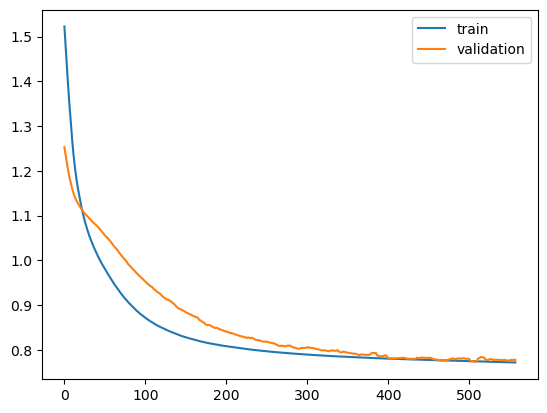

smape equals 10.133387623241168 with 1 time step as training
Train: 0.760, Test: 0.455


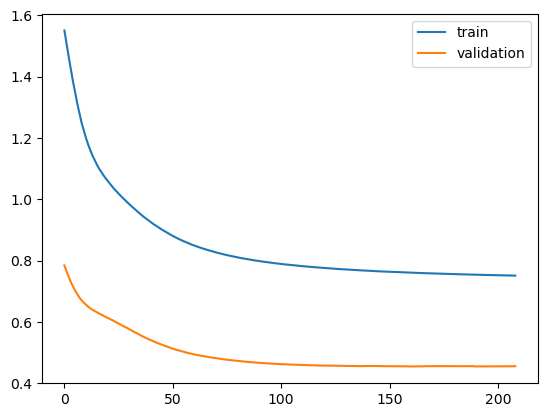

smape equals 7.583352722955568 with 2 time step as training
Train: 0.677, Test: 0.662


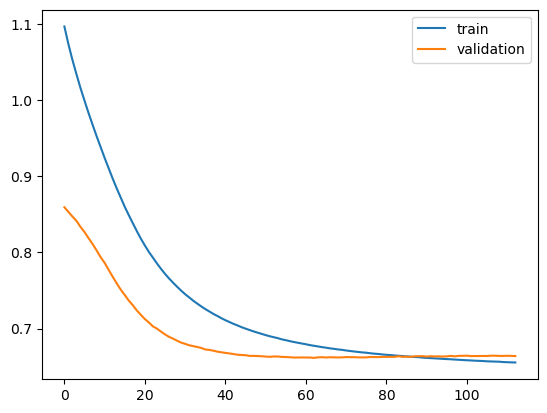

smape equals 9.914992822889136 with 3 time step as training
Train: 0.664, Test: 0.969


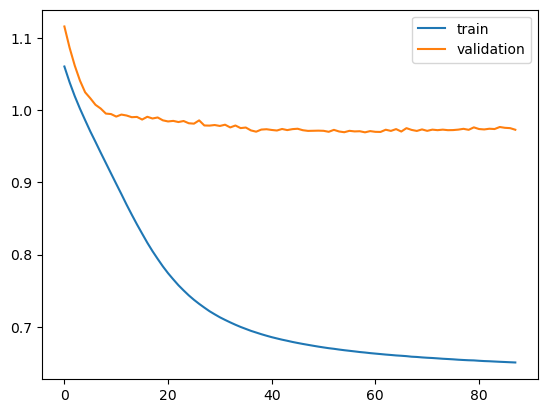

smape equals 12.797734507460031 with 4 time step as training
Train: 0.686, Test: 0.951


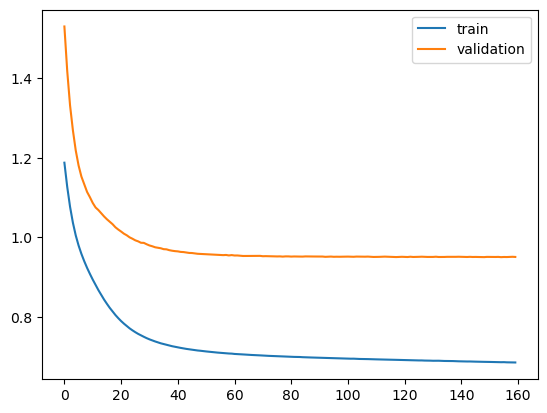

smape equals 13.362604099998014 with 5 time step as training
Train: 0.715, Test: 0.796


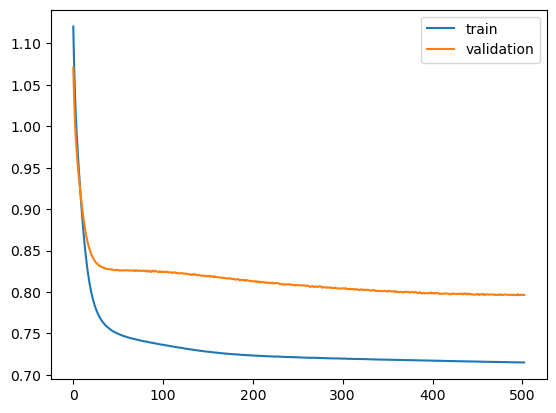

smape equals 10.20408312288553 with 6 time step as training
Train: 0.871, Test: 1.099


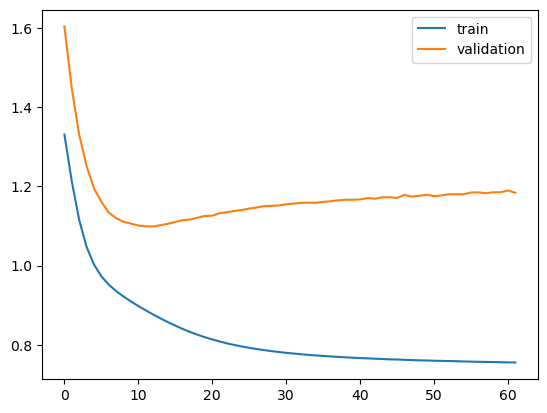

smape equals 13.835288745619051 with 7 time step as training
Train: 0.769, Test: 0.996


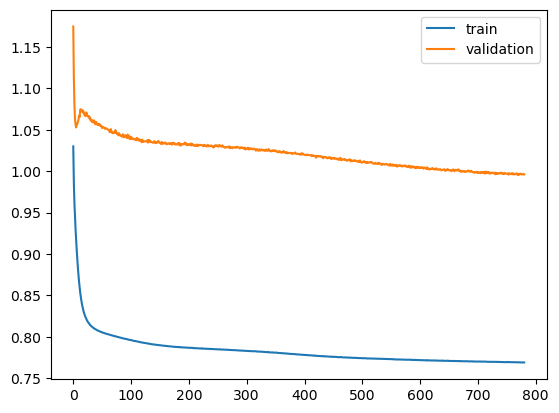

smape equals 14.518909346972503 with 8 time step as training
Train: 0.813, Test: 0.421


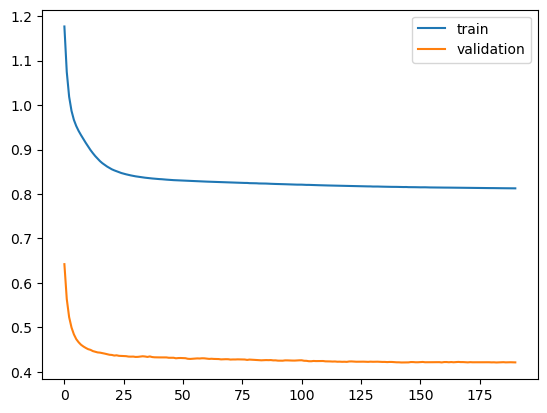

smape equals 7.1266038355370505 with 9 time step as training
Train: 1.086, Test: 0.676


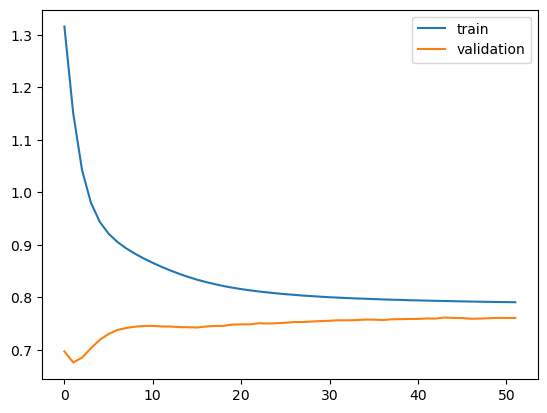

smape equals 9.432801754095859 with 10 time step as training
Train: 0.792, Test: 0.788


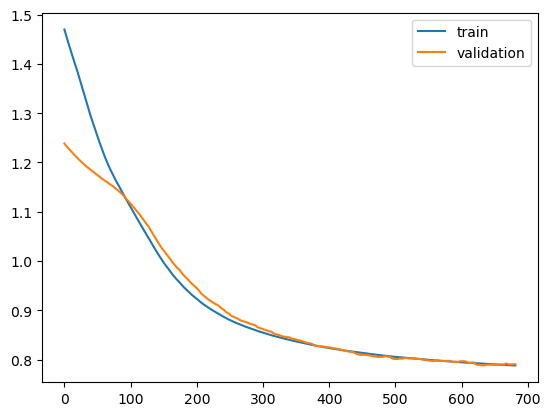

smape equals 10.326448123190833 with 1 time step as training
Train: 0.762, Test: 0.467


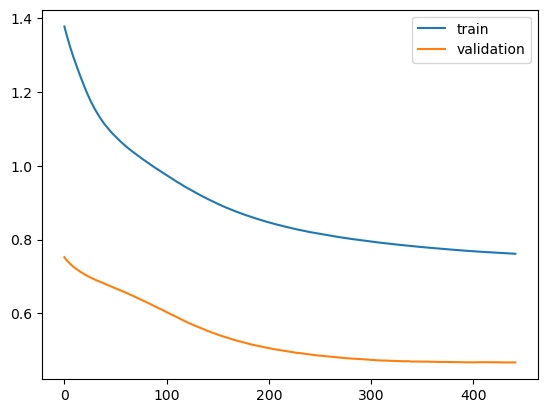

smape equals 7.662682511926667 with 2 time step as training
Train: 0.679, Test: 0.700


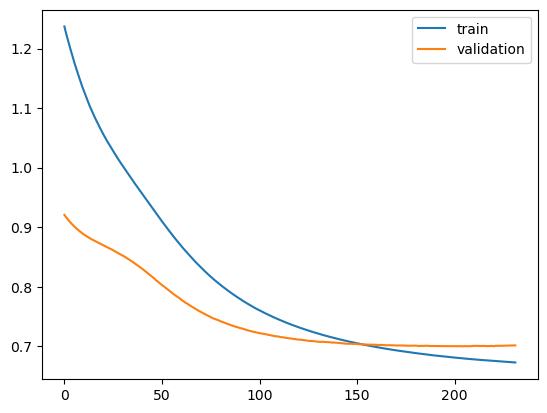

smape equals 10.09371401072314 with 3 time step as training
Train: 0.701, Test: 0.972


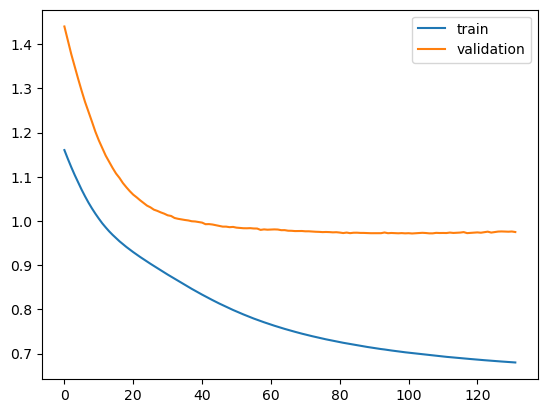

smape equals 12.924990020369416 with 4 time step as training
Train: 0.690, Test: 0.951


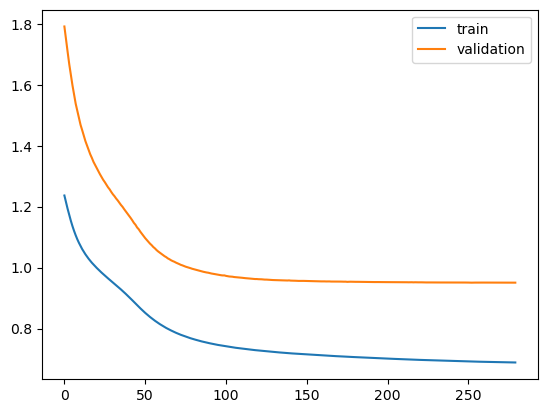

smape equals 13.410273300816124 with 5 time step as training
Train: 0.721, Test: 0.797


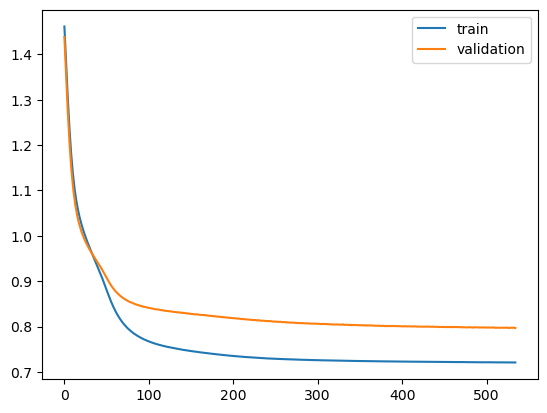

smape equals 10.256688719717403 with 6 time step as training
Train: 0.792, Test: 1.194


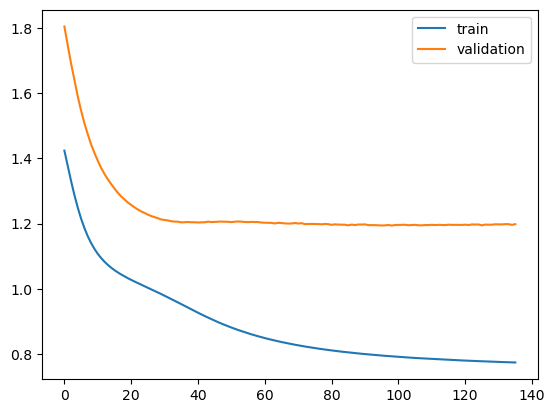

smape equals 14.262682243891392 with 7 time step as training
Train: 0.798, Test: 1.041


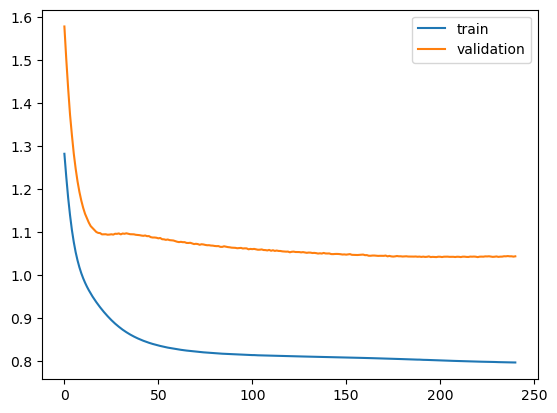

smape equals 15.001610626326237 with 8 time step as training
Train: 0.824, Test: 0.424


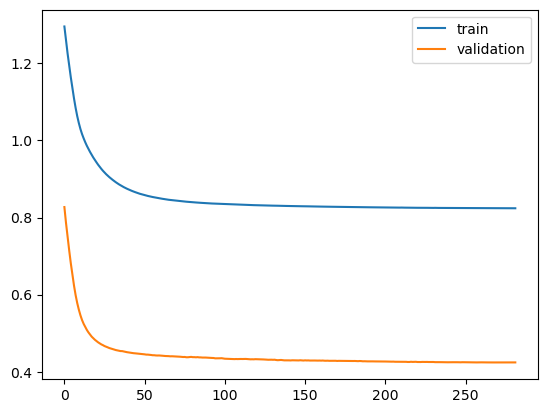

smape equals 7.2510394469826345 with 9 time step as training
Train: 0.784, Test: 0.755


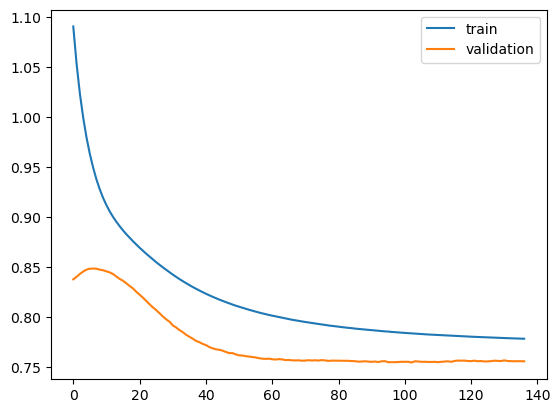

smape equals 9.568277765824922 with 10 time step as training
Train: 0.783, Test: 0.798


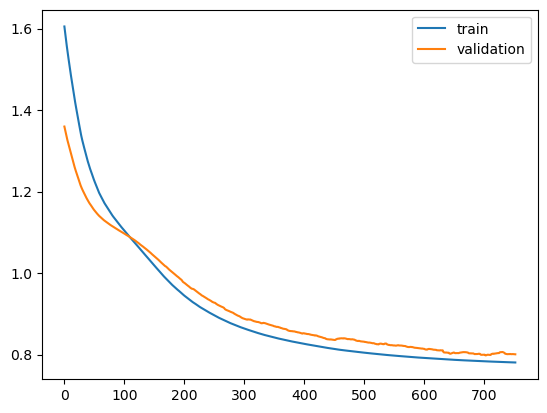

smape equals 10.337516883398527 with 1 time step as training
Train: 0.757, Test: 0.460


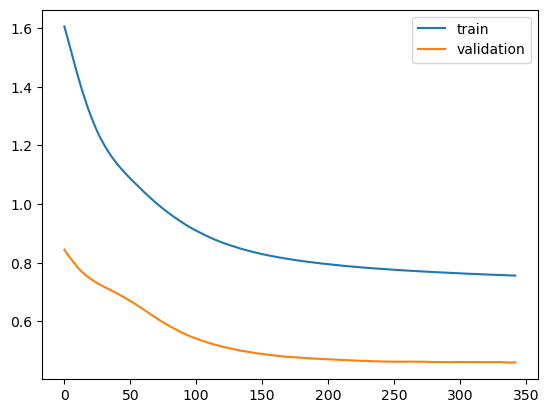

smape equals 7.621087734539649 with 2 time step as training
Train: 0.679, Test: 0.683


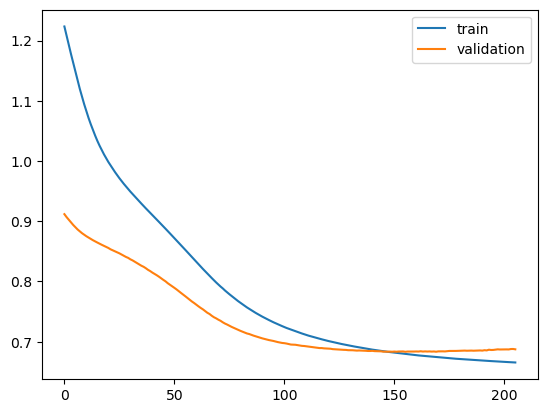

smape equals 9.994948734306055 with 3 time step as training
Train: 0.714, Test: 0.945


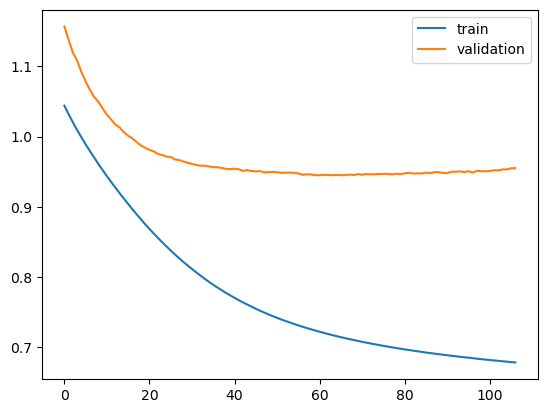

smape equals 12.847919568713685 with 4 time step as training
Train: 0.692, Test: 0.946


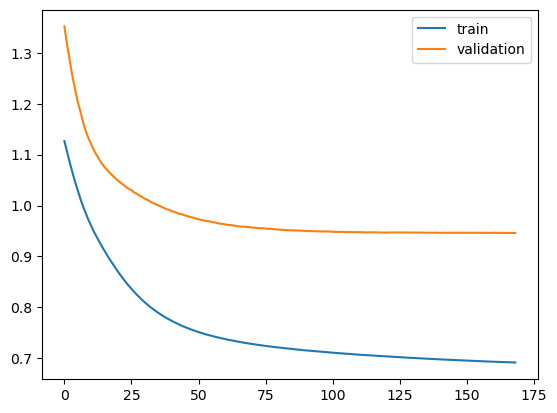

smape equals 13.32454827593397 with 5 time step as training
Train: 0.719, Test: 0.796


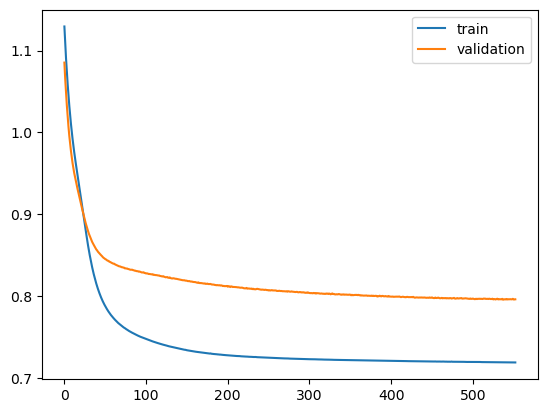

smape equals 10.22813906805424 with 6 time step as training
Train: 0.887, Test: 1.073


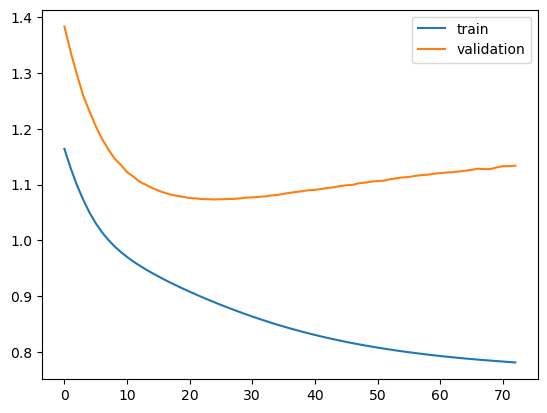

smape equals 13.71978068491444 with 7 time step as training
Train: 0.924, Test: 1.010


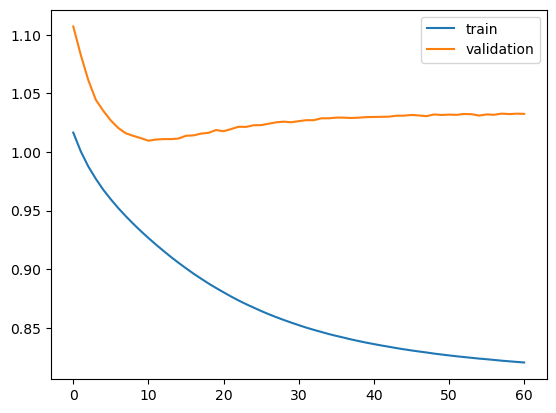

smape equals 14.995856063874209 with 8 time step as training
Train: 0.820, Test: 0.428


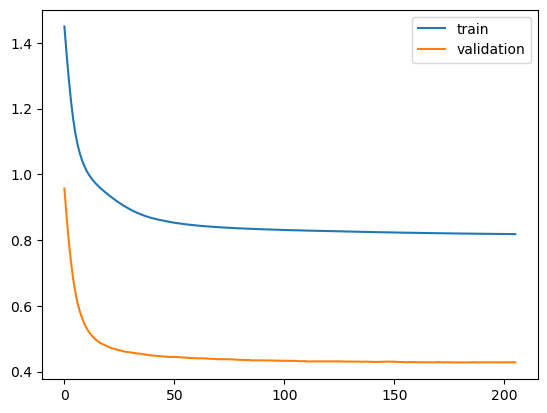

smape equals 7.210627036436389 with 9 time step as training
Train: 1.025, Test: 0.732


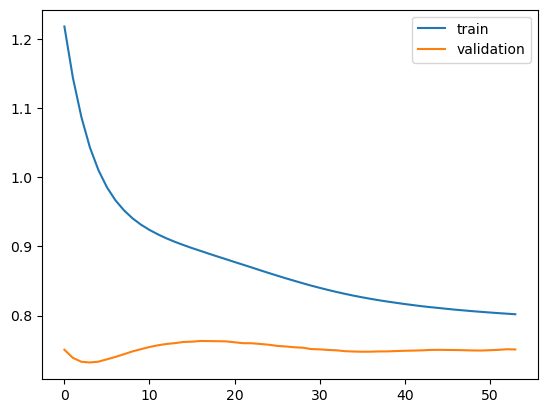

smape equals 9.701629455220464 with 10 time step as training
Train: 0.783, Test: 0.768


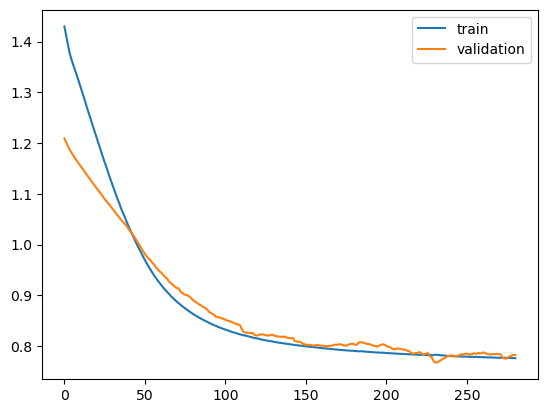

smape equals 10.17210539397987 with 1 time step as training
Train: 0.736, Test: 0.453


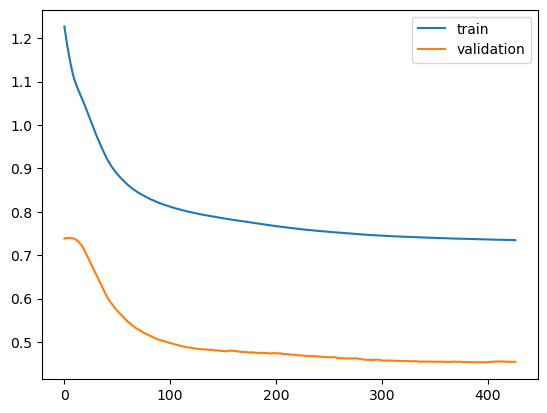

smape equals 7.59929068177645 with 2 time step as training
Train: 0.649, Test: 0.658


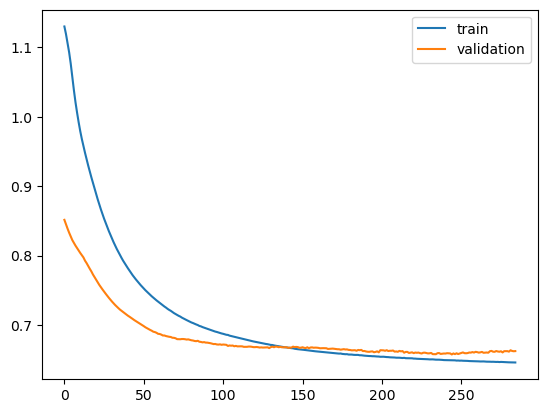

smape equals 9.85309095281393 with 3 time step as training
Train: 0.778, Test: 0.914


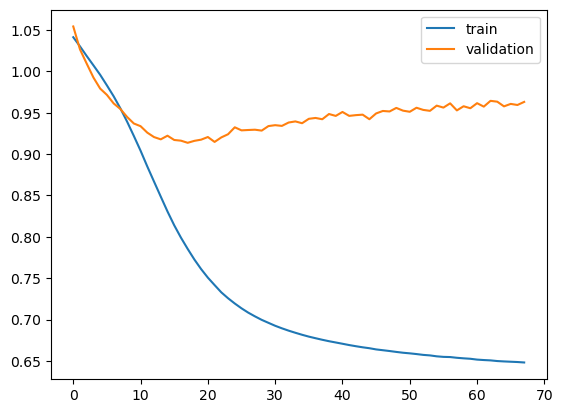

smape equals 12.713725027294945 with 4 time step as training
Train: 0.730, Test: 0.937


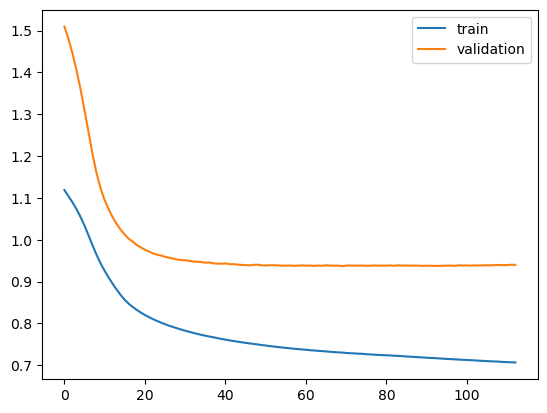

smape equals 13.13569460962006 with 5 time step as training
Train: 0.713, Test: 0.791


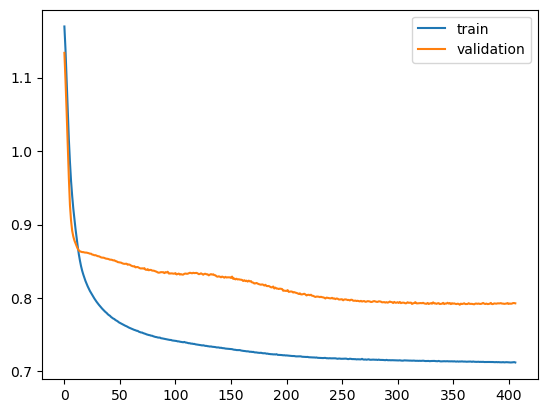

smape equals 10.0546035094327 with 6 time step as training
Train: 0.905, Test: 1.068


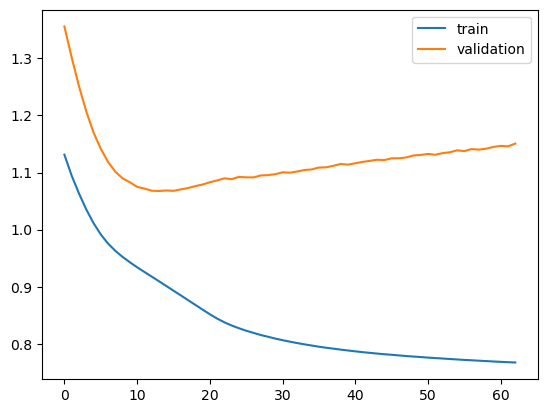

smape equals 13.62694208649759 with 7 time step as training
Train: 0.767, Test: 0.996


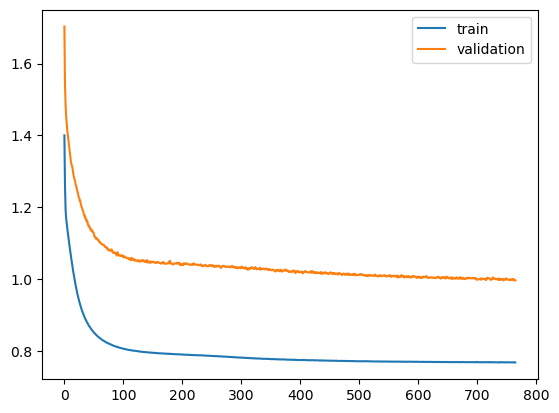

smape equals 14.451013373694229 with 8 time step as training
Train: 0.991, Test: 0.446


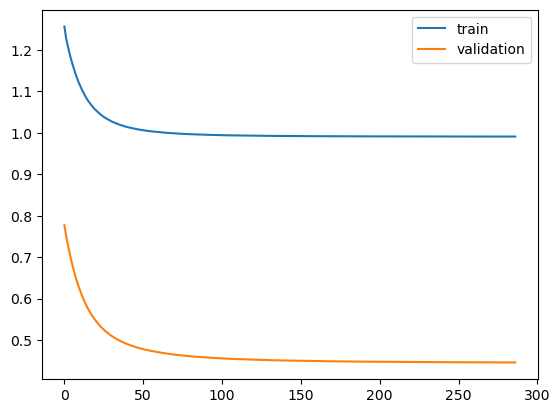

smape equals 7.091080952373537 with 9 time step as training
Train: 1.072, Test: 0.749


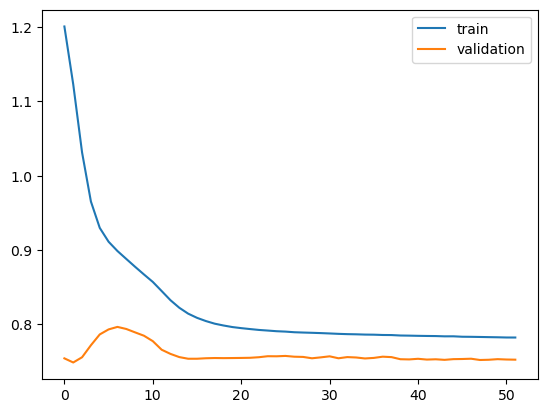

smape equals 9.838306021664135 with 10 time step as training
Train: 0.798, Test: 0.828


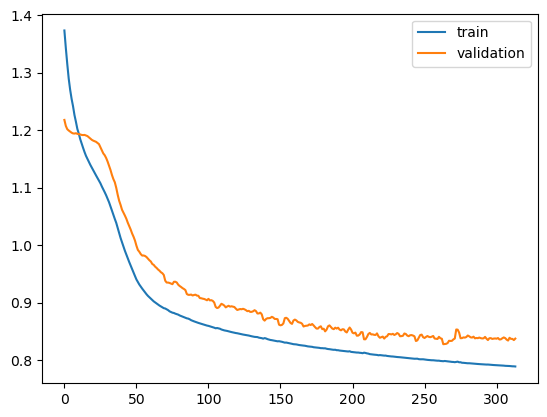

smape equals 10.58667807752898 with 1 time step as training
Train: 0.749, Test: 0.467


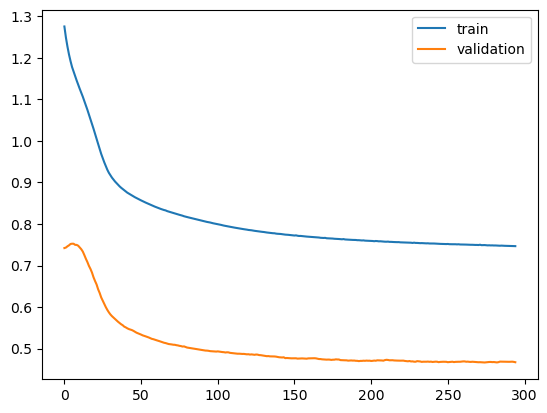

smape equals 7.678838765363476 with 2 time step as training
Train: 0.683, Test: 0.663


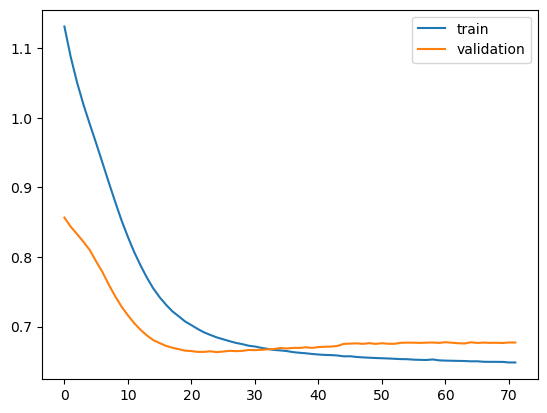

smape equals 9.888943519574042 with 3 time step as training
Train: 0.827, Test: 0.923


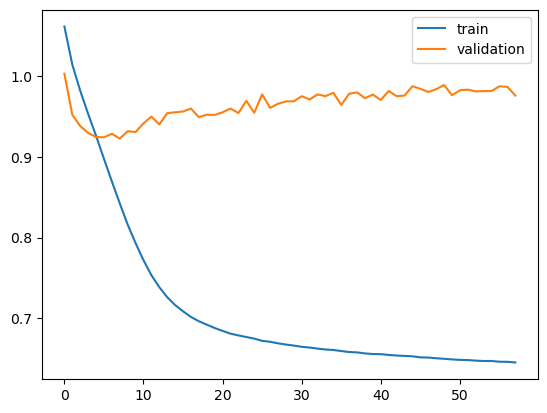

smape equals 12.85231983933892 with 4 time step as training
Train: 0.708, Test: 0.945


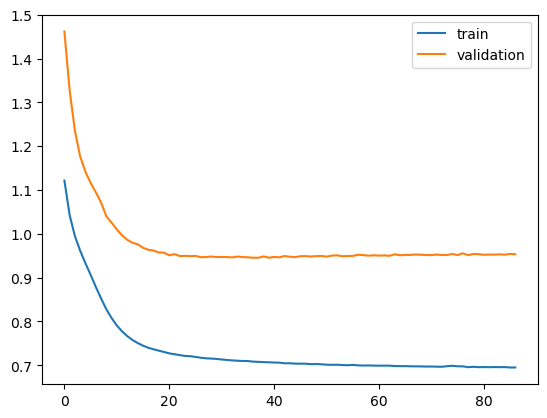

smape equals 13.176131805274252 with 5 time step as training
Train: 0.709, Test: 0.798


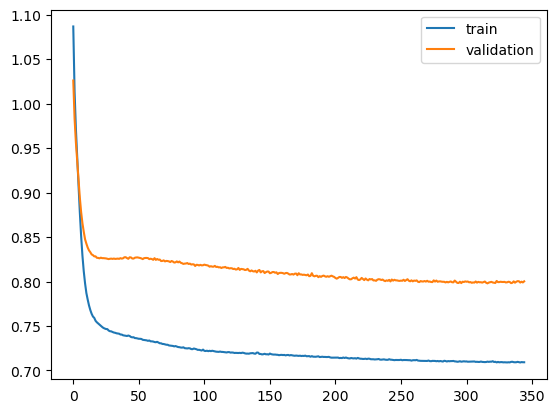

smape equals 10.14482281511659 with 6 time step as training
Train: 0.908, Test: 1.112


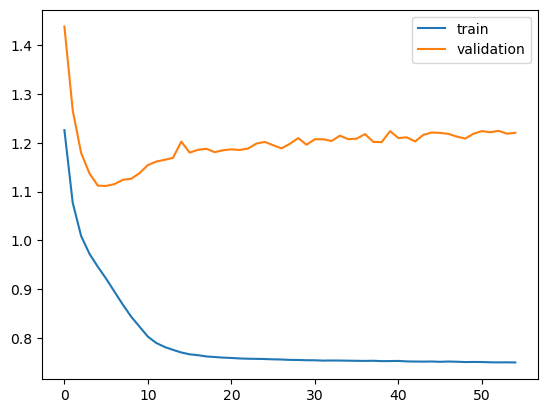

smape equals 13.939670579865167 with 7 time step as training
Train: 0.950, Test: 0.977


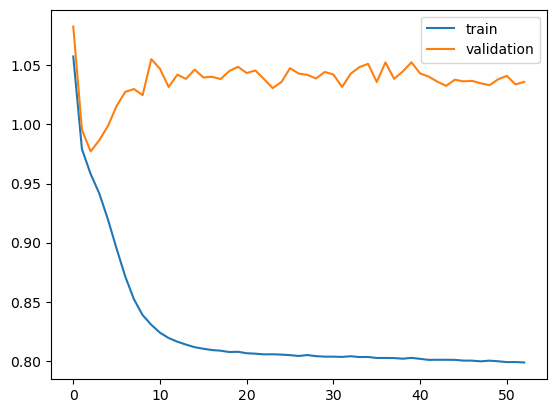

smape equals 14.675122649715712 with 8 time step as training
Train: 0.813, Test: 0.421


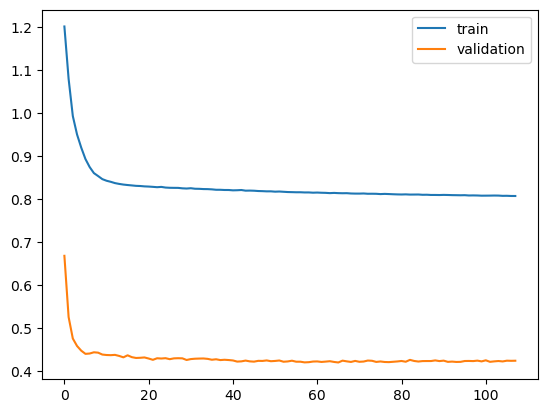

smape equals 7.123358768876642 with 9 time step as training
Train: 0.845, Test: 0.733


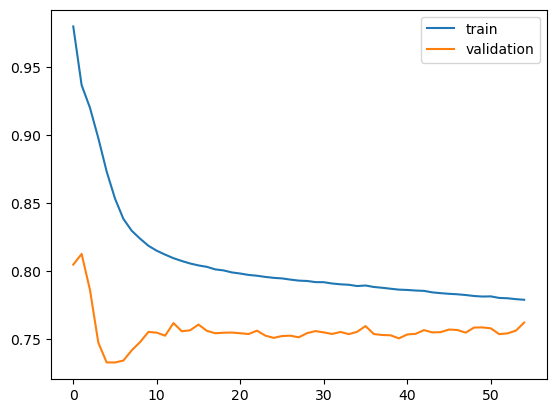

smape equals 9.528235312589533 with 10 time step as training
         layers activation  batchSize  averageSmape  varianceSmape
3     [4, 4, 4]       relu         16     10.853585              0
0          [10]       relu         16     10.890976              0
4  [10, 10, 10]       relu         16     10.959412              0
2        [3, 2]       relu         16     10.998205              0
1        [2, 2]       relu         16     11.075841              0


In [13]:
lays = [[10], [2,2], [3,2], [4,4,4], [10,10,10]]
epochs = [50]
batchSizes = [16]
activationFunctions = ['relu']

options = []

for layer in lays:
    for activation in activationFunctions:
        for batchSize in batchSizes:
                options.append([layer, activation, batchSize, 0, 0])


options = pd.DataFrame(options)
options = options.set_axis(['layers', 'activation', 'batchSize', 'averageSmape', 'varianceSmape'], axis=1)

# print(options.iloc[0].layers)

for i in range(len(options)):
    smape_avg=[]
    for j in range(1):
        smp, model = kfolds(train, [1,2,3,4,5,6,7,8,9,10], options.iloc[i])
        smape_avg.append(smp)

    options.iat[i,3] = np.mean(smape_avg)
    options.iat[i,4] = np.std(smape_avg)


op = pd.DataFrame(options)
res = op.sort_values(by="averageSmape")
print(res)

In [14]:
print(op.sort_values(by="averageSmape"))

         layers activation  batchSize  averageSmape  varianceSmape
3     [4, 4, 4]       relu         16     10.853585              0
0          [10]       relu         16     10.890976              0
4  [10, 10, 10]       relu         16     10.959412              0
2        [3, 2]       relu         16     10.998205              0
1        [2, 2]       relu         16     11.075841              0


In [15]:
##TESTING

predictions = pd.DataFrame()
observations = []
window_size = 3

df_full = pd.DataFrame()
df_full = df_train
df_full = df_full.drop(df_full.columns[14:], axis=1)

num_predictions = 6

# Make predictions using autoregressive approach
for pred in range(num_predictions):

    PF = []
    for index, row in df_full.iterrows():
        preprocessed, details = preprocess(np.array(row))
        PF.append(details[2:])
        observations.append([preprocessed[11+pred:14+pred],0, details, 14+pred]) #y is unknown and first time point to predict is 15(or 14?)`

    # Reshape the input for prediction
    x = []
    for i in (range(len(observations))):
        x.append(observations[i][0])
    x = np.array(x).reshape(len(x),window_size)
    
    # Make the prediction
    prediction = model.predict(x)

    y_u = []
    for i in range(len(prediction)):
        y_u.append(reprocess(prediction[i], observations[i]))

    # print(pd.DataFrame(y_u).shape)
    predictions[15+pred] = pd.DataFrame(pd.DataFrame(y_u))
    df_full[15+pred] = pd.DataFrame(y_u)

smapes = pd.DataFrame(columns=[i for i in range(num_predictions)])

for i in range(predictions.shape[0]):
    smape_row = []
    for j in range(num_predictions):
        smape_row.append(smape_clean(predictions.iloc[i, j], df_test.iloc[i, j]))
    smapes.loc[i] = smape_row

print(smapes)

smape_avgs = []
for i in range(num_predictions):
    smape_avgs.append(np.mean(smapes.iloc[:,i]))
print(smape_avgs)

5/5 [==============================] - 0s 892us/step
** On entry to DGELSD, parameter number  6 had an illegal value


/var/folders/b_/w2_d_pr10y73nq82f53t_m4c0000gn/T/ipykernel_35379/4186268508.py:3: RuntimeWarning: invalid value encountered in log
  PF1 = np.polyfit(np.linspace(0,len(data) - 1,num=len(data)), np.log(data), 1)


LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
# y = []
# y_hat = []
# details = []
# offset = 7
# for i in range(0,10):
#     y.append(observations[i+offset][1])
#     y_hat.append(y[i] + 0.4)
#     details.append(observations[i+offset])

# repY = []
# repY_hat = []
# smape = 0
# for i in range(10):
#     repY.append(reprocess(y[i], details[i]))
#     repY_hat.append(reprocess(y_hat[i], details[i]))
#     smape += smape_clean(repY[i], repY_hat[i])

# smape /= len(repY)
# print(smape)
# pyplot.plot(repY, label='original')
# pyplot.plot(repY_hat, label='altered')
# pyplot.plot(df_train.iloc[1,3:10], label = 'og')
# pyplot.legend()
# pyplot.show()